In [1]:
import tensorflow as tf
import numpy as np
import shutil
import os

## The PDE example

The PDE equation is:
$$\nabla{\Psi}^2(x,y) = e^{-x}(x-2+y^3+6y)$$

With the following condition:
$$x,y \in [0,1]$$
$$\Psi(0,y) = y^3, \quad \Psi(1,y) = (1+y^3)e^{-1}$$
$$\Psi(x,0) = xe^{-x}, \quad \Psi(x,1) = (x+1)e^{-x}$$

The trial neural form of the solution which satisflies the constraints above is assumed to be:

$$\Psi_{t}(x,y) = A(x,y)+x(1-x)y(1-y)N(x,y,\vec{p})$$

Where $N(x,y,\vec{p})$ is the output of the neural network, $\vec{p}$ are the parameters of the neural network. $A(x,y)$ is defined as:

$$A(x,y) = (1-x)y^3+x(1+y^3)e^{-1}+(1-y)x(e^{-x}-e^{-1})+y[(1+x)e^{-x}-(1-x-2xe^{-1})]$$

The analytic solution is:
    
$$\Psi_{a}(x, y) = e^{-x}(x+y^3)$$

## Function for the PDE

In [2]:
def trial_neural_form_solution(x, y, network_output):
    with tf.name_scope('Psi_networks'):
        A =  (1.-x)*tf.pow(y, 3) + x*(1+tf.pow(y, 3))*tf.exp(-1.) + (1.-y)*x*( tf.exp(-x) - tf.exp(-1.) ) + \
             y*( (1.+x)*tf.exp(-x) - (1-x+2*x*tf.exp(-1.)) )

    return     A + x*(1-x)*y*(1-y)*network_output


def d_Psi_from_eq(x, y, network_output):
    
    with tf.name_scope('d_Psi_from_eq'):
        d_Psi = tf.exp(-x)*(x-2.+tf.pow(y, 3)+6.*y)
    
    return d_Psi


def d_Psi_from_cal(x, y, network_output):
    
    with tf.name_scope('d_Psi_from_cal'):
        Psi_network = trial_neural_form_solution(x, y, network_output)

        d_Psi_network_dxx = tf.gradients(tf.gradients(Psi_network, x)[0], x)[0]
        d_Psi_network_dyy = tf.gradients(tf.gradients(Psi_network, y)[0], y)[0]

        d_Psi = d_Psi_network_dxx + d_Psi_network_dyy
        
    return d_Psi

    
def analytic_sol(x, y):
    '''
        Analytical solution of current problem
    '''
    return np.exp(-x)*( x + np.power(y, 3) )


## Input data and analytic solution

In [3]:
# training data
nx_train, ny_train = (10, 10)

x_train = np.linspace(0, 1, nx_train, dtype="float32")
y_train = np.linspace(0, 1, ny_train, dtype="float32")

x_train, y_train = np.meshgrid(x_train, y_train)

x_train = x_train.flatten().reshape(-1, 1)

y_train = y_train.flatten().reshape(-1, 1)


# prediction data
nx_predict, ny_predict = (15, 15)

x_predict = np.linspace(0, 1, nx_predict, dtype="float32")
y_predict = np.linspace(0, 1, ny_predict, dtype="float32")

x_predict, y_predict = np.meshgrid(x_predict, y_predict)

x_predict = x_predict.flatten().reshape(-1, 1)
y_predict = y_predict.flatten().reshape(-1, 1)

psi_analytic = analytic_sol(x_predict, y_predict)

## Build the neural network

In [4]:
# Parameters
learning_rate = 0.001
num_steps = 500
display_step = 100
batch_size = 100
data_length = len(x_train[:,0])

# Network Parameters
n_hidden_1 = 10 # 1st layer number of neurons
num_input = 2 # data input
num_output = 1

In [5]:
# tf Graph input
with tf.name_scope('Inputs'):
    x_feeds = tf.placeholder(tf.float32, shape = [None, 1])
    y_feeds = tf.placeholder(tf.float32, shape = [None, 1])
    input_data = tf.concat([ x_feeds, y_feeds],1)

In [6]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, num_output]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([num_output]))
}

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Create a flow for network model
def neural_net(x):
  
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)

    # Output fully connected layer with a neuron for each class
    outputs = tf.matmul(layer_1, weights['out']) + biases['out']

    return outputs

In [8]:
# Define feed forward flow
network_output = neural_net(input_data)

In [9]:
# Define loss and optimizer
Psi_network = trial_neural_form_solution(x_feeds, y_feeds, network_output)
Psi_network = tf.identity(Psi_network, name="predict_output")

d_Psi_from_eq_val = d_Psi_from_eq(x_feeds, y_feeds, network_output)
d_Psi_from_cal_val = d_Psi_from_cal(x_feeds, y_feeds, network_output)

with tf.name_scope('Loss'):
    loss_op = tf.sqrt(tf.reduce_mean(tf.squared_difference(d_Psi_from_cal_val, d_Psi_from_eq_val)))

with tf.name_scope('Train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss_op)


Instructions for updating:
Use tf.cast instead.


In [10]:
# Check the file path for saving the model
folderpath = "./tmp/model"
filepath = folderpath+"/test_model"

if os.path.exists(folderpath):
    shutil.rmtree(folderpath)
    
os.makedirs(folderpath)

tf.add_to_collection("input_x", x_feeds)
tf.add_to_collection("input_y", y_feeds)
tf.add_to_collection("psi_value", Psi_network)

In [11]:
# Start training

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# create saver object
saver = tf.train.Saver()


with tf.Session() as sess:
 
    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={x_feeds: x_train , y_feeds: y_train })

        if step % display_step == 0 or step == 1:
           
            # Calculate batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={x_feeds: x_train , y_feeds: y_train })
            print ("Step " + str(step) + ", Loss = " + "{:.4f}".format(loss) )
            
    print ("Training Finished!")

    # save model     
    save_path = saver.save(sess, filepath)
    print("Model saved in file: %s" % save_path)

Step 1, Loss = 2.6104
Step 100, Loss = 2.0988
Step 200, Loss = 1.6041
Step 300, Loss = 1.1297
Step 400, Loss = 0.7002
Step 500, Loss = 0.3967
Training Finished!
Model saved in file: ./tmp/model/test_model


## Restore the model and predict

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:
    
    # 使用 import_meta_graph 載入計算圖
    saver = tf.train.import_meta_graph(filepath+".meta")
    saver.restore(sess, tf.train.latest_checkpoint(folderpath))
    
    graph = tf.get_default_graph()
    
    input_x = tf.get_collection("input_x")[0]
    input_y = tf.get_collection("input_y")[0]
    ouput_again = tf.get_collection("psi_value")[0]
    
    psi_predict_network = sess.run(ouput_again, feed_dict = {input_x: x_predict, input_y: y_predict})


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./tmp/model\test_model


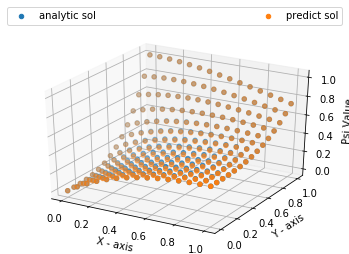

In [14]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x_predict[:,0], y_predict[:,0], psi_analytic, label="analytic sol") 
ax.scatter(x_predict[:,0], y_predict[:,0], psi_predict_network,  label="predict sol")

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)



ax.set_xlabel('X - axis')
ax.set_ylabel('Y - axis')
ax.set_zlabel('Psi Value')
ax.grid()
plt.savefig('ANN_for_PDE.png')
plt.show()